In [1]:
import glob
import os
import imageio
import skimage as ski
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from skimage.feature import SIFT, match_descriptors
from sklearn.cluster import KMeans
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.neighbors import NearestNeighbors
#https://scikit-learn.org/0.15/modules/generated/sklearn.neighbors.NearestNeighbors.html
"""
Resources used:
    https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.SIFT
"""

'\nResources used:\n    https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.SIFT\n'

In [2]:
def grey_list(paths):
    
    gray_list =[] #for path in paths:
    detector_list = []
    i = 0
    for path in paths:    
        image = imageio.v2.imread(path)
        gray_image = ski.color.rgb2gray(image) #this turns each pixel into a float 0-1
        gray_list.append(gray_image)
        sift_stuff(gray_image, detector_list)
    return detector_list

def sift_stuff(image, list):
    #descriptors are the local image gradient info, around the keypoint
    descriptor_extractor= SIFT()
    descriptor_extractor.detect_and_extract(image)
    list.append(descriptor_extractor.descriptors) # appending x amount of descriptors, each descriptor has 128 features
    
    

In [3]:

paths = sorted(glob.glob('Childrens-Books/*.jpg'))

sift_list = grey_list(paths)

In [4]:

    #https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=1000)
flat_array = np.vstack(sift_list)
mean_list = kmeans.fit(flat_array) #needs a 1D array

In [14]:
with open('kmeans_data.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [70]:
with open('kmeans_data.pkl', 'rb') as f:
    kmean_data_backup = pickle.load(f)

In [5]:
#create a list which correlates to the order of images in childrens book which is the prediction of which clusters appear
    
cluster_list = []
for item in sift_list:
    if item is not None and len(item) > 0:
        val = kmeans.predict(item)
        cluster_list.append(val)
    else: 
        print(item, "not valid")

In [6]:
#convert the elements of the above list into strings
str_list = []
for index, cluster in enumerate(cluster_list):
    local_string = ""
    for x in range(len(cluster)):
        local_string += str(cluster[x]) + " "
    str_list.append(local_string)
    
    

In [7]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(str_list) 

knn = NearestNeighbors(n_neighbors=5, metric='cosine')# 5 because for queries I am finding 5 nearest images
knn.fit(tfidf_matrix)

NearestNeighbors(metric='cosine')

In [10]:

def predict(input_list, output_list):
    for item in input_list:
        if item is not None and len(item) > 0:
            val = kmeans.predict(item)
            output_list.append(val)
        else: 
            print("Incorrect item")

In [11]:
queries_list = []
path_query = sorted(glob.glob('queries/*.jpg'))

queries_list = grey_list(path_query)

output_list =[]
predict(queries_list, output_list)



In [12]:
queries_str_list = []
for index, cluster in enumerate(output_list):
    local_string = ""
    for x in range(len(cluster)):
        local_string += str(cluster[x]) + " "
    queries_str_list.append(local_string)
    


In [55]:
print(path_query)
print(path_query[0])
query_index = 0

['queries/are-you-my-mother.jpg', 'queries/charlottes-web.jpg', 'queries/dont-let-the-pigeon-drive-the-bus.jpg', 'queries/lego-ideas-book.jpg', 'queries/room-on-the-broom.jpg', 'queries/stuck.jpg']
queries/are-you-my-mother.jpg


In [56]:
query_transform = vectorizer.transform([queries_str_list[query_index]])

In [57]:
distances, indices = knn.kneighbors(query_transform)

In [58]:
print(distances, indices)

[[0.5709932  0.57312279 0.57767833 0.57918887 0.58223688]] [[355 187 320 423 272]]


In [59]:
indices = np.array(indices)
indices = indices.flatten().tolist()

/tmp/ipykernel_940/2203114905.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path_query[query_index])


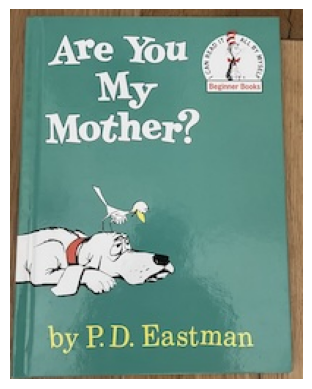

In [60]:

image = imageio.imread(path_query[query_index])
plt.imshow(image)
plt.axis('off')
plt.show()

[355, 187, 320, 423, 272]


/tmp/ipykernel_940/3586159962.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  query_image = imageio.imread(path_query[query_index])
/tmp/ipykernel_940/3586159962.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(paths[image_index])  # Read the image from path


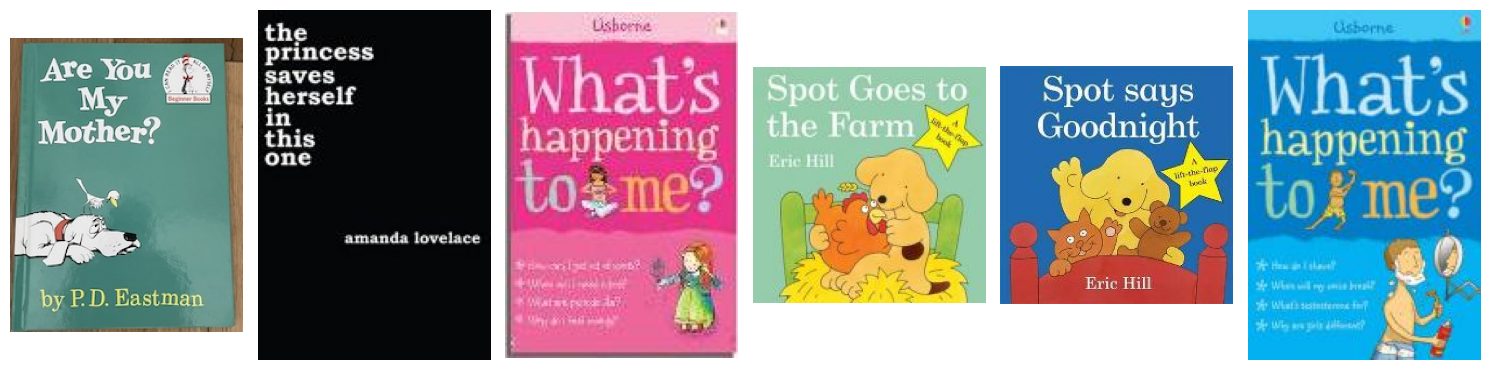

In [62]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))  # Create 5 subplots horizontally
print(indices)
query_image = imageio.imread(path_query[query_index])
plt.imshow(query_image)
axes[0].imshow(query_image)
axes[0].axis("off")
# Loop through the paths and display each image in a subplot
for i, ax in enumerate(axes[1:],start=1 ):
    image_index = indices[i-1]
    image = imageio.imread(paths[image_index])  # Read the image from path
    ax.imshow(image)                  # Show the image
    ax.axis('off')                    # Hide axes for each subplot

plt.tight_layout()  # Adjust subplots to fit into figure area
plt.show()